<a href="https://colab.research.google.com/github/nik-hil-29/Projects_Ai-ML/blob/main/Flower_102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flower-dataset-102:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F403293%2F773427%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240406%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240406T125058Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D326910df9d3f6937ebc602fc52e9b00041f5f68d5149f2a07d941a12ee6661bd6ff8f7fde47cc3a42aca31fd07a0a8d5c0213bf61a6aedae25ac37c968966292916e4f14161740d1128a97b940b4f111b58ae6068d095b6505ad4d0f7cd5d4b05910549eaab2841bd682711f0174512ebc3455c8c3c6c991977a2876b6065e9746ee27f956f951636c8368d2f9f70af9004bfbbababc0cba94dd67c7e76bff3644fff5a272e4aea999d4f1a72140f5ffd5d92752aae5abf8f3d8b7b227b99ebb640f390b4b7791a6a72404b07dbde8306555052add0c1993b22a34bd08bbcd35c9329e0bb9c5a319b6c8bcf985db9608f401cfdcf24abdb33e9cf1a656d39ed2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 344968140 bytes downloaded
Downloaded and uncompressed: flower-dataset-102
Data source import complete.


### Installing all the libriaries and dependencies

In [3]:
# Standard Imports for working with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.io
import tarfile
import csv
import sys
import os

# Neural Network frameworks
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, Callback
#from tensorflow.keras.regularizers import l2
#from tensorflow.applications.inception_v3 import Inception_v3
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split

# Image output modules
import PIL
from PIL import ImageOps, ImageFilter

# Image visual output settings
from pylab import rcParams
rcParams['figure.figsize'] == 10, 5
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Print Versions and datasets available if everything is ok
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Checking the versions
print(f"""
Python version: {sys.version[0:3]}
Numpy: {np.__version__}
Tensorflow: {tf.__version__}
""")


/kaggle/input/flower-dataset-102/imagelabels.mat
/kaggle/input/flower-dataset-102/102flowers.tgz

Python version: 3.1
Numpy: 1.25.2
Tensorflow: 2.15.0



### Setting up the configs for the future modelling

In [5]:
!pwd

/content


In [4]:
# All the main settings for NN will be listed below for convinient

EPOCHS = 50
BATCH_SIZE = 128
LR = 1e-3
VAL_SPLIT = 0.2

CLASS_NUM = 102
IMG_SIZE = 128
IMG_CHANNELS = 3
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/kaggle/input/flower-dataset-102/'
PATH = '/kaggle/working/flower/'

### Importing the data

In [5]:
# Get all the data from the archive files in the directory
def get_filenames(tgz):
    with tarfile.open(tgz) as file:
        return[i.name for i in file.getmembers() if i.isfile()]


df = pd.DataFrame()
df['Id'] = sorted(get_filenames(DATA_PATH + '102flowers.tgz'))
df['Category'] = scipy.io.loadmat(DATA_PATH + 'imagelabels.mat')['labels'][0] - 1 # classes for earch 0,..,N
df['Category'] = df['Category'].astype('str')

# Explore if everything is ok
df.head(4)

,Id,Category
0,jpg/image_00001.jpg,76
1,jpg/image_00002.jpg,76
2,jpg/image_00003.jpg,76
3,jpg/image_00004.jpg,76


In [6]:
df['Category'].value_counts()

Category
50    258
76    251
45    196
72    194
88    184
     ... 
6      40
44     40
33     40
0      40
26     40
Name: count, Length: 102, dtype: int64

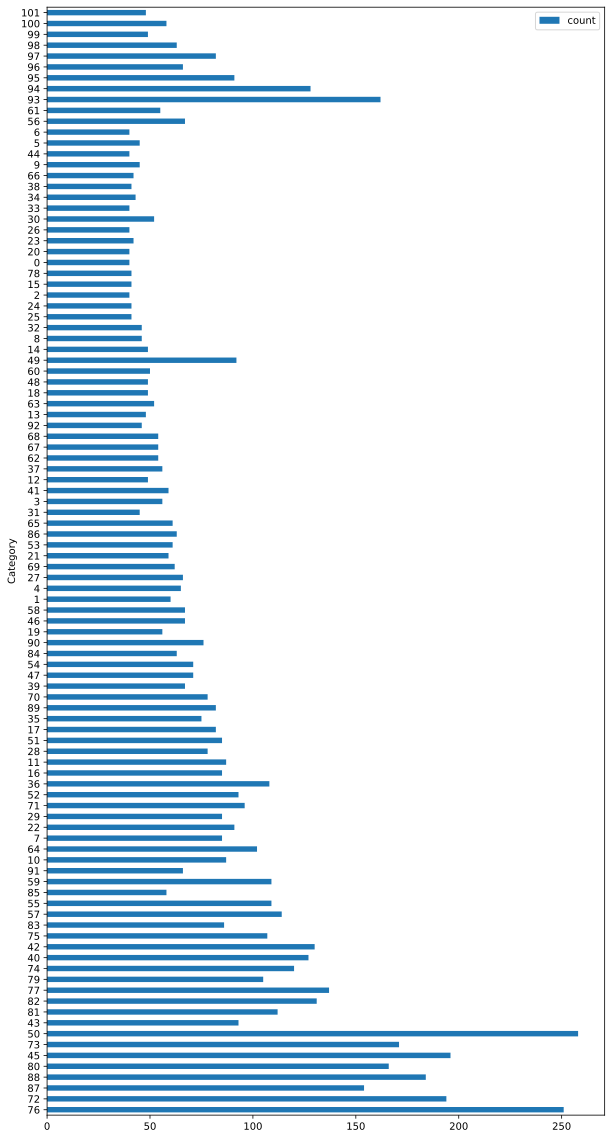

In [7]:
# Due to imbalanced classes we need to perform something with this
pd.DataFrame(df['Category'].value_counts(sort=False)).plot(kind='barh', figsize=(10, 20));

In [8]:
# How much classes in the dataset
print(f"Dataset contains {df['Category'].nunique()} classes.")

Dataset contains 102 classes.


In [9]:
# Unzipping the images that are in the dataset
opened_tgz = tarfile.open(DATA_PATH + "102flowers.tgz")
opened_tgz.extractall(PATH)

# Check the files
print(os.listdir(PATH + 'jpg')[:12])

['image_06779.jpg', 'image_04922.jpg', 'image_05727.jpg', 'image_06193.jpg', 'image_04480.jpg', 'image_01673.jpg', 'image_07013.jpg', 'image_02180.jpg', 'image_05674.jpg', 'image_06493.jpg', 'image_07264.jpg', 'image_07905.jpg']


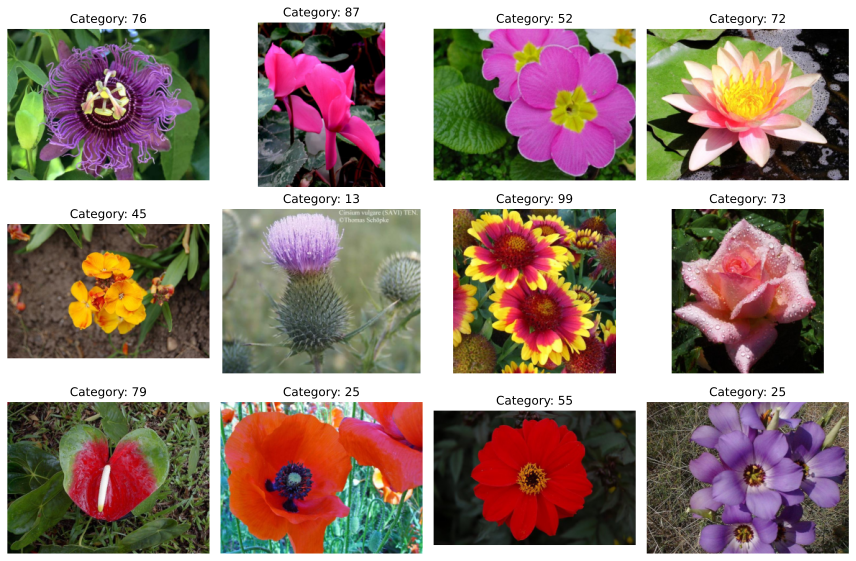

In [10]:
import matplotlib.pyplot as plt
import PIL

# Example of the images that dataset contains
plt.figure(figsize=(12, 8))

# Selecting random images
random_images = df.sample(n=12)
random_image_paths = random_images['Id'].values
random_image_categories = random_images['Category'].values

for i, path in enumerate(random_image_paths):
    image = PIL.Image.open(PATH + path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(image)
    plt.title("Category: " + str(random_image_categories[i]))
    plt.axis("off")

plt.tight_layout()
plt.show()

In [11]:
# train/test splitting
X_train, X_test, y_train, y_test = train_test_split(df['Id'], df['Category'], test_size = 0.2, stratify = df['Category'])

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train['Category'] = y_train
X_test['Category'] = y_test

print(f"Shape of the Train Data: {X_train.shape}\nShape of the Test Data: {X_test.shape}")

Shape of the Train Data: (6551, 2)
Shape of the Test Data: (1638, 2)


### Data Augmentation and Generator Creation

In [ ]:
# pip install tensorflow-gpu


  ERROR: Command errored out with exit status 1:
   command: /opt/conda/bin/python3.7 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-84dy1vth/tensorflow-gpu/setup.py'"'"'; __file__='"'"'/tmp/pip-install-84dy1vth/tensorflow-gpu/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-hw9kar2z
       cwd: /tmp/pip-install-84dy1vth/tensorflow-gpu/
  Complete output (17 lines):
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "/tmp/pip-install-84dy1vth/tensorflow-gpu/setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  informatio

In [12]:
# Augmentation is very important part when you do not have a big data to train the model
train_datagen = ImageDataGenerator(rescale = 1. / 255,
                                   rotation_range = 50, shear_range = 0.2,
                                   zoom_range = [0.75, 1.25],
                                   brightness_range = [0.5, 1.5],
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [13]:
# Wrapping all data to the generator
train_generator = train_datagen.flow_from_dataframe(dataframe = X_train, directory = PATH, x_col = 'Id', y_col = "Category",
                                                    target_size = (IMG_SIZE, IMG_SIZE), batch_size = BATCH_SIZE, class_mode = 'categorical',
                                                    shuffle = True, seed = 42)

test_generator = test_datagen.flow_from_dataframe(dataframe = X_test, directory = PATH, x_col = 'Id', y_col = "Category",
                                                  target_size = (IMG_SIZE, IMG_SIZE), batch_size = BATCH_SIZE, class_mode = 'categorical',
                                                 shuffle = False, seed = 42)


Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


Image Train example:


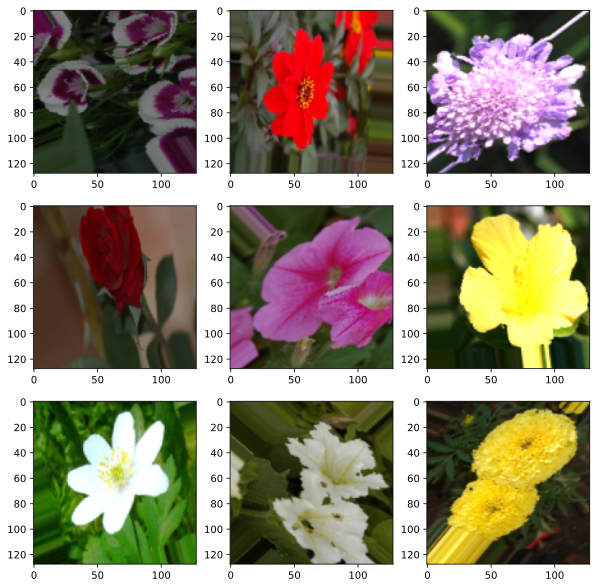

In [14]:
from skimage import io

def imshow(image):
    io.imshow(image)
    io.show()

x, y = train_generator.next()
print("Image Train example:")
plt.figure(figsize = (10, 10))

for i in range(0, 9):
    image = x[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)

plt.show();

### Neural Network Modelling

In [15]:
input_shape

(128, 128, 3)

In [16]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Constructing the model
model = Sequential()

# Adding layers
model.add(Conv2D(128, (3, 3), input_shape=input_shape, activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(CLASS_NUM, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary of the model
model.summary()

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 128)     512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 128)     512       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 128)       0         
 D)                                                              
                                                        

### Model Training

In [21]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [17]:
tf.keras.backend.clear_session()

In [18]:
# LR = 0.01
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adamax(learning_rate = LR), metrics = ['accuracy'])

In [23]:
checkpoint = ModelCheckpoint('/gdrive/MyDrive/best_model.hdf5', monitor = ['val_accuracy'], verbose = 1, mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)
callbacks_list = [checkpoint, earlystop]

In [24]:
scores = model.evaluate_generator(test_generator, steps = 1, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

1/1 [==============================] - 1s 754ms/step - loss: 8.8675 - accuracy: 0.0078
Accuracy: 0.78%


In [25]:
# Training
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples // train_generator.batch_size,
                              validation_data = test_generator,
                              validation_steps= test_generator.samples//test_generator.batch_size,
                              epochs = 10,
                              callbacks = callbacks_list)

Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 17.4393 - accuracy: 0.0269
Epoch 1: saving model to /gdrive/MyDrive/best_model.hdf5
51/51 [==============================] - 119s 2s/step - loss: 17.4393 - accuracy: 0.0269 - val_loss: 37.2119 - val_accuracy: 0.0202
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 5.5073 - accuracy: 0.0294
Epoch 2: saving model to /gdrive/MyDrive/best_model.hdf5
51/51 [==============================] - 110s 2s/step - loss: 5.5073 - accuracy: 0.0294 - val_loss: 10.0765 - val_accuracy: 0.0273
Epoch 3/10
51/51 [==============================] - ETA: 0s - loss: 5.1315 - accuracy: 0.0280
Epoch 3: saving model to /gdrive/MyDrive/best_model.hdf5
51/51 [==============================] - 105s 2s/step - loss: 5.1315 - accuracy: 0.0280 - val_loss: 4.6378 - val_accuracy: 0.0286
Epoch 4/10
51/51 [==============================] - ETA: 0s - loss: 5.0061 - accuracy: 0.0285
Epoch 4: saving model to /gdrive/MyDrive/best_model.hdf5
51

### Transfer Learning.

In [26]:
base_model = tf.keras.applications.ResNet50V2(weights = 'imagenet', include_top = False, input_shape = input_shape)

94668760/94668760 [==============================] - 0s 0us/step


In [27]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 66, 66, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

In [28]:
model = M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(512, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dense(CLASS_NUM, activation = 'softmax'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 102)               52326     
                                                                 
Total params: 24668262 (94.10 MB)
Trainable params: 2462

In [30]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adamax(learning_rate = LR), metrics = ['accuracy'])

In [31]:
checkpoint = ModelCheckpoint('/gdrive/MyDrive/best_model.hdf5', monitor = ['val_accuracy'], verbose = 1, mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)
callbacks_list = [checkpoint, earlystop]

In [32]:
scores = model.evaluate_generator(test_generator, steps = 1, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

1/1 [==============================] - 6s 6s/step - loss: 5.8451 - accuracy: 0.0078
Accuracy: 0.78%


In [34]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples // train_generator.batch_size,
                              validation_data = test_generator,
                              validation_steps= test_generator.samples // test_generator.batch_size,
                              epochs = 25,
                              callbacks = callbacks_list)

Epoch 1/25
51/51 [==============================] - ETA: 0s - loss: 0.1626 - accuracy: 0.9513
Epoch 1: saving model to /gdrive/MyDrive/best_model.hdf5
51/51 [==============================] - 61s 1s/step - loss: 0.1626 - accuracy: 0.9513 - val_loss: 0.7097 - val_accuracy: 0.8171
Epoch 2/25
51/51 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.9598
Epoch 2: saving model to /gdrive/MyDrive/best_model.hdf5
51/51 [==============================] - 60s 1s/step - loss: 0.1417 - accuracy: 0.9598 - val_loss: 0.5239 - val_accuracy: 0.8555
Epoch 3/25
51/51 [==============================] - ETA: 0s - loss: 0.1711 - accuracy: 0.9498
Epoch 3: saving model to /gdrive/MyDrive/best_model.hdf5
51/51 [==============================] - 58s 1s/step - loss: 0.1711 - accuracy: 0.9498 - val_loss: 0.5924 - val_accuracy: 0.8490
Epoch 4/25
51/51 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9636
Epoch 4: saving model to /gdrive/MyDrive/best_model.hdf5
51/51 [==

In [37]:
model.save('/gdrive/MyDrive/best_model.hdf5')
model.load_weights('/gdrive/MyDrive/best_model.hdf5')

In [38]:
scores = model.evaluate_generator(test_generator, steps = 1, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

1/1 [==============================] - 0s 461ms/step - loss: 0.5448 - accuracy: 0.8516
Accuracy: 85.16%


In [39]:
def plot_history(history):
    plt.figure(figsize = (10, 5))
    plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label = 'Training accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
    plt.title("Training and validation accuracy")
    plt.legend()


    plt.figure(figsize = (10,5))
    plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

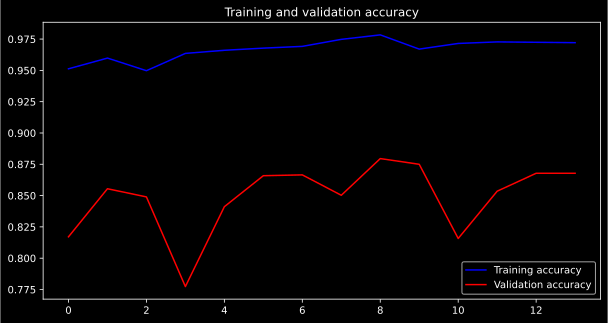

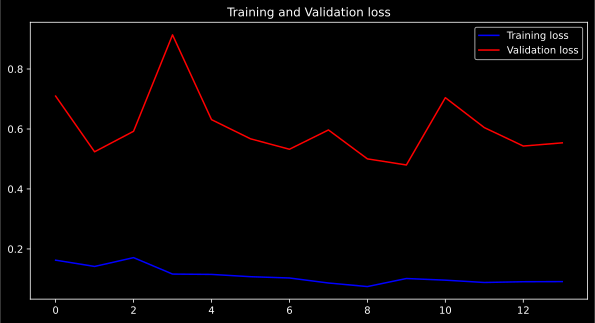

In [41]:
plot_history(history)

### Transfer Learning with freezing weights.

In [42]:
base_model.trainable = False

In [44]:
model = M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(CLASS_NUM, activation = 'softmax'))

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 102)               208998    
                                                                 
Total params: 23773798 (90.69 MB)
Trainable params: 208998 (816.40 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [46]:
len(model.trainable_variables)

2

In [47]:
# Check the trainable status of the individual layers
for i in model.layers:
    print(i, i.trainable)

<keras.src.engine.functional.Functional object at 0x7d4c2b9b05e0> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7d4c1410cbe0> True
<keras.src.layers.core.dense.Dense object at 0x7d4be0142800> True


In [49]:
LR = 0.001
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adamax(learning_rate = LR), metrics = ['accuracy'])
checkpoint = ModelCheckpoint('/gdrive/MyDrive/best_model.hdf5', monitor = ['val_accuracy'], verbose = 1, mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)
callbacks_list = [checkpoint, earlystop]

In [50]:
scores = model.evaluate_generator(test_generator, steps = 1, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

1/1 [==============================] - 2s 2s/step - loss: 4.8502 - accuracy: 0.0000e+00
Accuracy: 0.00%


In [51]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples // train_generator.batch_size,
                              validation_data = test_generator,
                              validation_steps= test_generator.samples // test_generator.batch_size,
                              epochs = 15,
                              callbacks = callbacks_list)

Epoch 1/15
51/51 [==============================] - ETA: 0s - loss: 2.2357 - accuracy: 0.6073
Epoch 1: saving model to /gdrive/MyDrive/best_model.hdf5
51/51 [==============================] - 54s 1s/step - loss: 2.2357 - accuracy: 0.6073 - val_loss: 1.0686 - val_accuracy: 0.8236
Epoch 2/15
51/51 [==============================] - ETA: 0s - loss: 0.6137 - accuracy: 0.9340
Epoch 2: saving model to /gdrive/MyDrive/best_model.hdf5
51/51 [==============================] - 54s 1s/step - loss: 0.6137 - accuracy: 0.9340 - val_loss: 0.6675 - val_accuracy: 0.8646
Epoch 3/15
51/51 [==============================] - ETA: 0s - loss: 0.3760 - accuracy: 0.9583
Epoch 3: saving model to /gdrive/MyDrive/best_model.hdf5
51/51 [==============================] - 51s 1s/step - loss: 0.3760 - accuracy: 0.9583 - val_loss: 0.5536 - val_accuracy: 0.8737
Epoch 4/15
51/51 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.9623
Epoch 4: saving model to /gdrive/MyDrive/best_model.hdf5
51/51 [==

In [52]:
# Number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  190


In [53]:
base_model.trainable = True

# fine tune from this layers to the end
fine_tune_at = 100

# freeze all other layers before the fine_tune_at layer:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"The number of trainable vars: {len(base_model.trainable_variables)}")

The number of trainable vars: 82


In [55]:
LR = 0.0001

model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adamax(learning_rate = LR), metrics = ['accuracy'])
checkpoint = ModelCheckpoint('/gdrive/MyDrive/best_model.hdf5', monitor = ['val_accuracy'], verbose = 1, mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)
callbacks_list = [checkpoint, earlystop]

In [56]:
scores = model.evaluate_generator(test_generator, steps = 1, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

1/1 [==============================] - 2s 2s/step - loss: 0.3807 - accuracy: 0.8750
Accuracy: 87.50%


In [57]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples // train_generator.batch_size,
                              validation_data = test_generator,
                              validation_steps= test_generator.samples // test_generator.batch_size,
                              epochs = 15,
                              callbacks = callbacks_list)

Epoch 1/15
51/51 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9784
Epoch 1: saving model to /gdrive/MyDrive/best_model.hdf5
51/51 [==============================] - 70s 1s/step - loss: 0.0920 - accuracy: 0.9784 - val_loss: 0.3456 - val_accuracy: 0.8952
Epoch 2/15
51/51 [==============================] - ETA: 0s - loss: 0.0596 - accuracy: 0.9865
Epoch 2: saving model to /gdrive/MyDrive/best_model.hdf5
51/51 [==============================] - 59s 1s/step - loss: 0.0596 - accuracy: 0.9865 - val_loss: 0.3338 - val_accuracy: 0.8971
Epoch 3/15
51/51 [==============================] - ETA: 0s - loss: 0.0513 - accuracy: 0.9897
Epoch 3: saving model to /gdrive/MyDrive/best_model.hdf5
51/51 [==============================] - 53s 1s/step - loss: 0.0513 - accuracy: 0.9897 - val_loss: 0.3273 - val_accuracy: 0.8997
Epoch 4/15
51/51 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9885
Epoch 4: saving model to /gdrive/MyDrive/best_model.hdf5
51/51 [==

In [58]:
model.save('/gdrive/MyDrive/best_model.hdf5')
model.load_weights('/gdrive/MyDrive/best_model.hdf5')

In [61]:
scores = model.evaluate_generator(test_generator, steps = 10, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

10/10 [==============================] - 5s 467ms/step - loss: 0.3135 - accuracy: 0.9164
Accuracy: 91.64%


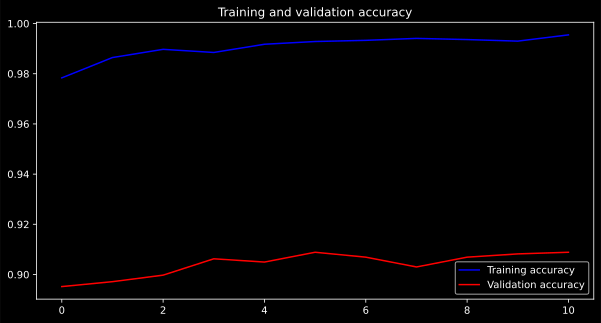

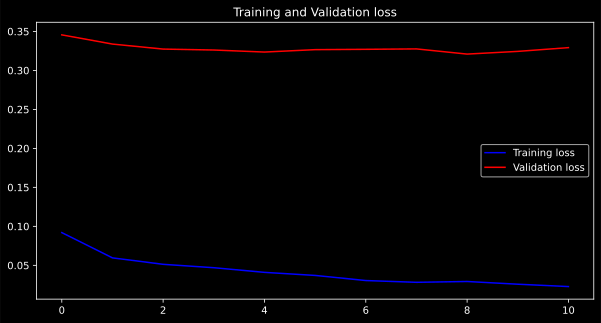

In [62]:
plot_history(history)